# Configuración Inicial

In [6]:
import geopandas as gpd
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
r_state = 42

ruta2 = r"C:\Users\Usuario\OneDrive\Escritorio\UOC\TFM\PEC3  - Implementacion\WorkStation\Datos\Variables\Procesados\Secciones2"

# Importar dataframes y crear conjuntos train y test

## Importar dataframes

In [8]:
path_2011 = r"C:\Users\Usuario\OneDrive\Escritorio\UOC\TFM\PEC3  - Implementacion\WorkStation\Datos\Variables\Procesados\Secciones2\df_2011.csv"
path_2021 = r"C:\Users\Usuario\OneDrive\Escritorio\UOC\TFM\PEC3  - Implementacion\WorkStation\Datos\Variables\Procesados\Secciones2\df_2021.csv"
df_2011 = pd.read_csv(path_2011, sep=";")
df_2021 = pd.read_csv(path_2021, sep=";")

df_2011.rename(columns={'SES_11': 'SES', 'he_pct_11': 'he_pct', 'kw_pct_11': 'kw_pct', 'median_price_inf_11': 'median_price_inf','RANK_11':'RANK','SES_PR_11':'SES_PR'}, inplace=True)
df_2021.rename(columns={'SES_21': 'SES', 'he_pct_21': 'he_pct', 'kw_pct_21': 'kw_pct', 'median_price_inf_21': 'median_price_inf','RANK_21':'RANK','SES_PR_21':'SES_PR'}, inplace=True)
#print(df_2011.columns)
#print(df_2021.columns)

## Conjunto train y test

In [10]:
# Se dividen los conjuntos usando 80/20 respectivamente
train, test = train_test_split(df_2011, test_size = 0.2, random_state = r_state)

x_train = train.loc[:, ~train.columns.isin(["SES","he_pct","kw_pct","median_price_inf","RANK","SES_PR"])]
y_train = train.loc[:, train.columns == 'SES']

x_test = test.loc[:, ~test.columns.isin(["SES","he_pct","kw_pct","median_price_inf","RANK","SES_PR"])]
y_test = test.loc[:, test.columns == 'SES']

# Crear Modelo Regresión Linear

In [13]:
# Import package:
from sklearn.linear_model import LinearRegression

# Entrenar modelo
lm = LinearRegression().fit(x_train, y_train)

# Predecir datos de 2011 con el modelo
y_pred_lm = lm.predict(x_test)

In [15]:
# Importar metricas
from sklearn.metrics import (mean_absolute_error as mae, mean_squared_error as mse, 
                             explained_variance_score as evs, r2_score as r2)

def mape(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

# Evaluar rendimiento del modelo
mae_lm = mae(y_test, y_pred_lm)
mse_lm = mse(y_test, y_pred_lm)
evs_lm = evs(y_test, y_pred_lm)
r2_lm = r2(y_test, y_pred_lm)
mape_lm = mape(y_test, y_pred_lm)

print(f"mae_lm: {mae_lm}, \nmse_lm: {mse_lm}, \nevs_lm: {evs_lm}, \nr2_lm: {r2_lm}, \nmape_lm: {mape_lm}")

mae_lm: 0.6625284374844664, 
mse_lm: 0.6683624713691828, 
evs_lm: 0.5111148475481373, 
r2_lm: 0.511069020946429, 
mape_lm: 639.7969116191833


## Kfold Validation

In [18]:
kfold = KFold(n_splits=5, shuffle=True, random_state=r_state)  # 5 pliegues
scores = cross_val_score(lm, x_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
print(f"Mean Cross-Validation Score: {np.mean(scores)}")
print(f"Standard Deviation: {np.std(scores)}")

Mean Cross-Validation Score: -0.556743463710945
Standard Deviation: 0.0719238664903988


# Usar la regresión lineal para predecir la gentrificación de 2021 

In [21]:
# Definir datos de entrada al modelo 2021
X_21 = df_2021.loc[:, ~df_2021.columns.isin(["SES","he_pct","kw_pct","median_price_inf","RANK","SES_PR"])]

# Crear nuevo dataset para guardar los resultados
df_2021_lm = df_2021.copy()

# Predecir con el modelo de regresion lineal la gentrificación de 2021
df_2021_lm['Predicted_SES_21'] = lm.predict(X_21)

# Crear dataset con datos espaciales

In [23]:
cartografia_seccion_shp_path = r"C:\Users\Usuario\OneDrive\Escritorio\UOC\TFM\PEC3  - Implementacion\WorkStation\Datos\Shapefiles\da_cartografiaSeccionCensal-25830\da_cartografiaSeccionCensalPolygon.shp"
df_cartografia_seccion = gpd.read_file(cartografia_seccion_shp_path)

# Unir con shapefile
seccion_df_2021_lm = df_cartografia_seccion.merge(df_2021_lm, on = "NUMSECCENS")

## Visualizar datos

<Axes: >

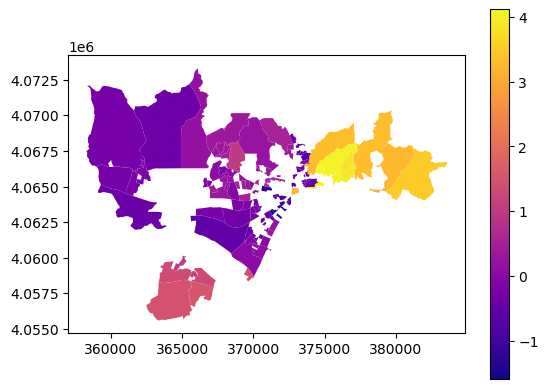

In [25]:
seccion_df_2021_lm.plot(column='SES', cmap="plasma", legend=True)

<Axes: >

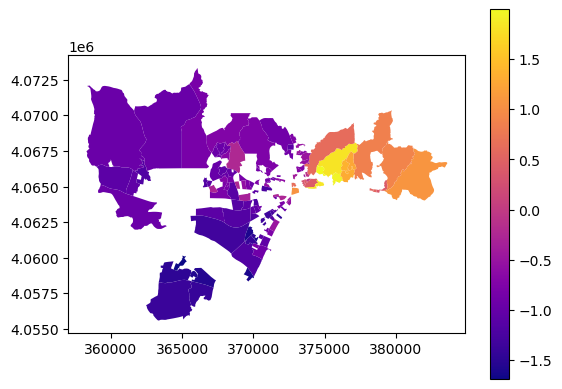

In [27]:
seccion_df_2021_lm.plot(column='Predicted_SES_21', cmap="plasma", legend=True)

## Visualizar diferencia SES secciones

<Axes: >

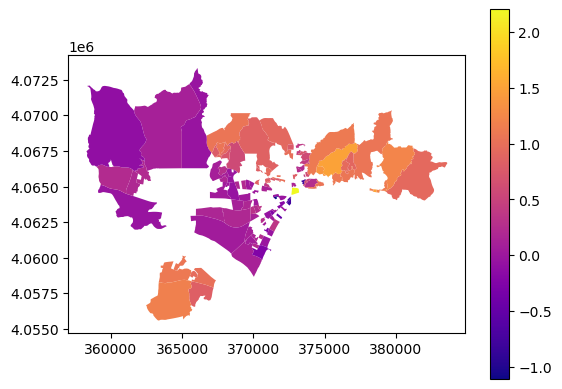

In [30]:
df_merged = df_2011.merge(df_2021, on='NUMSECCENS', suffixes=('_2011', '_2021'))

# Calcular la diferencia de SES entre 2021 y 2011
df_merged['SES_diff'] = df_merged['SES_2021'] - df_merged['SES_2011']

cartografia_seccion_shp_path2 = r"C:\Users\Usuario\OneDrive\Escritorio\UOC\TFM\PEC3  - Implementacion\WorkStation\Datos\Shapefiles\da_cartografiaSeccionCensal-25830\da_cartografiaSeccionCensalPolygon.shp"
df_cartografia_seccion2 = gpd.read_file(cartografia_seccion_shp_path)

seccion_df_2021_diff = df_cartografia_seccion2.merge(df_merged, on = "NUMSECCENS")

seccion_df_2021_diff.plot(column='SES_diff', cmap="plasma", legend=True)